# Hyperparameter optimization: Contextualized embeddings 

Grand et al data

Hyperparameter optimization on a development set.

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt
import pickle

# Reading the data

## Contextualized embeddings

In [2]:
# global settings
num_randseeds = 3
feature_dim = 1024
whichbert = "robltop4"

In [3]:
#bert_large_vecs_paths = { "ltop4-plus16" : "bert-large-uncased.npz",
#                          "ltop4" : "bert-large-uncased.top4layers.npz",
#                          "l16" : "bert-large-uncased_layer16.npz" }

bert_large_vecs_paths = { "ltop4" : "bert-large-uncased.top4layers.Grandetal.npz",
                          "robltop4" : "roberta-large.Grandetal.top4layers.pkl"}
                         
print("using contextualized embeddings", bert_large_vecs_paths[whichbert], "\n")

filename = bert_large_vecs_paths[whichbert]
if filename.endswith("npz"):
    # for npz files:
    data = np.load(bert_large_vecs_paths[whichbert])
elif filename.endswith("pkl"):
    # for pkl files:
    with open(bert_large_vecs_paths[whichbert], "rb") as f:
        data2 = pickle.load(f)
        data = dict([(w, v.numpy()) for w, v in data2.items()])
else:
    raise Exception("should not be here")



using contextualized embeddings roberta-large.Grandetal.top4layers.pkl 



In [4]:
word_vectors = {}
    
for word in data:
    vector = data[word]
    if ' ' in word:
        first, second = word.split()
        if 'north' in first and 'dakota' in second:
            word = first + '_' + second
            print(word)
            word_vectors[word] = vector
        else:
            word = first + '-' + second
            print(word)
            word_vectors[word] = vector
    else:
        word_vectors[word] = vector
        


ping-pong
new-york
south-dakota
hong-kong
san-francisco
los-angeles
west-virginia
new-mexico
rhode-island
new-hampshire
new-jersey
north-carolina
south-carolina
north_dakota


## Grand features

In [5]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [6]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [7]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

We assume results that are dictionaries. 

First, a function for aggregating results by particular labels, into a single dictionary. For example, when results are aggregated by category and feature, the result will be a dictionary whose keys are category/feature tuples, and the values are lists of result dictionaries. 

Second, a function that computes mean, median, and standard deviation, over a list of result dictionaries, for a given labels.

In [8]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval


# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

# given a dictionary of results (parameters -> result dictionary list),
# * for each parameter setting, aggregate by cateogy and feature
# * for each category/feature, compute mean ocp and mse values
# * for the parameter setting, compute mean and sd ocp and mse over all category/feature pairs
def eval_hyper(results, parameternames):
    # output dictionary
    results_byparam = [ ]

    # iterate over parameter settings
    for theseresults in results.values():
        # extract parameters
        this_dict = dict([(par, theseresults[0][par]) for par in parameternames])
        
        # aggregate by condition = by category and feature
        results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
        
        # compute mean ocp and mse values.
        # ocp: we use mean for each condition.
        # mse: we use median for each condition
        ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
        mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]

        # compute mean and standard deviation over ocps and mses
        this_dict["ocp_mean"] = statistics.mean(ocps)
        this_dict["ocp_sd"] = statistics.stdev(ocps)
        this_dict["msemed_mean"] = statistics.mean(mses)
        this_dict["msemed_sd"] = statistics.stdev(mses)
        
        results_byparam.append(this_dict)
        
    return results_byparam


# Making a development set

In [9]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests n times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [10]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(oval, jval, ocp_mean, mse_med)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)
    


0.1 True 0.5084075586655448 731.5800779308611
0.2 True 0.49656343593939034 586.6746030131802
0.3 True 0.487489008848392 548.4167632500759
0.4 True 0.5198910295828243 737.4281468803784
0.5 True 0.5075380737276776 757.4512844090834
0.6 True 0.512274598654776 921.8735097119386
0.7 True 0.5001504322211078 906.7396739969158
0.7999999999999999 True 0.5183354873177382 661.7556044420614
0.8999999999999999 True 0.5056997239807384 816.9190393139183
0.9999999999999999 True 0.5219651461797439 757.0895707018444
1.0999999999999999 True 0.5095427850196019 719.0409933612447
1.2 True 0.5022738640615164 593.0884271725384
1.3 True 0.5051131311539666 991.2196229013823
1.4 True 0.5099025203466641 786.5733454443583
1.5 True 0.49276909066775537 939.6037191170597
1.5999999999999999 True 0.49759289672479773 923.1261928812903
1.7 True 0.5120641094343396 711.4732823109603
1.8 True 0.5033328539479278 910.8013288124715
1.9 True 0.49871147260533144 892.1281044758357
2.0 True 0.49174327326171696 741.2064768724392
0.

In [11]:
df = pd.DataFrame(eval_hyper(results, ["offset", "j"]))
df.head()


,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.1,True,0.519317,0.024839,653.367437,490.151221
1,0.2,True,0.501321,0.026294,614.388751,533.151746
2,0.3,True,0.510446,0.034954,619.105048,472.827991
3,0.4,True,0.511690,0.015142,535.493837,418.385712
4,0.5,True,0.508153,0.019768,779.656323,829.424237


We plot mean OC_P values, with standard deviation. 

<AxesSubplot: xlabel='offset'>

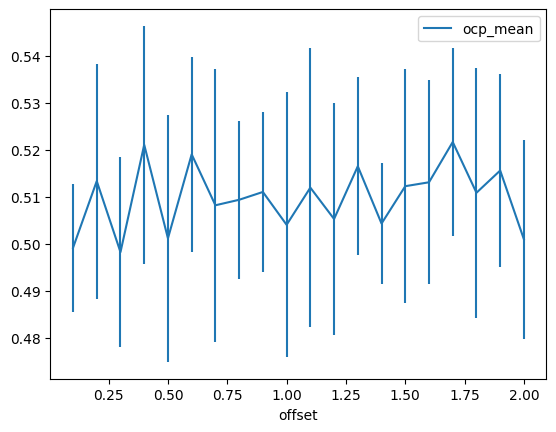

In [12]:
%matplotlib inline
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_sd")

<AxesSubplot: xlabel='offset'>

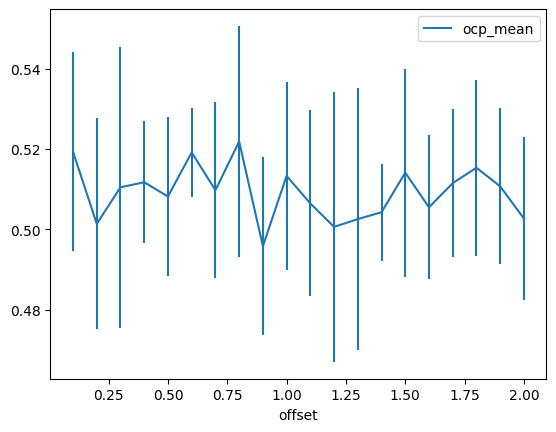

In [13]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_sd")

We plot mean values of median MSE, with standard deviation. 

<AxesSubplot: xlabel='offset'>

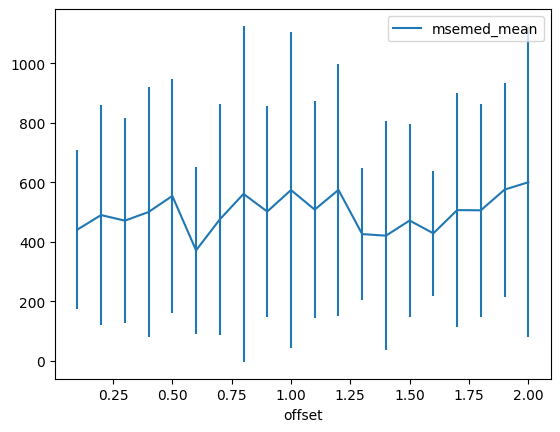

In [14]:
df[df.j == False].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

<AxesSubplot: xlabel='offset'>

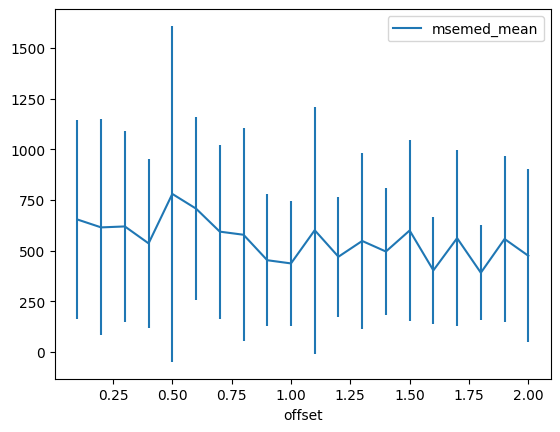

In [15]:
df[df.j == True].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

### Parameters for seeds as words


**BERT, last 4 layers**:

The differences in performance are small compared to the error bars. So we go with an **offset of 1.0 with no jitter**, same as for GLoVE.  
**RoBERTA, last 4 layers**:

We again go with an **offset of 1.0 with no jitter**, for the same reason.


In [16]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
7,0.8,True,0.521832,0.028791,578.075996,525.268923
36,1.7,False,0.521680,0.019883,506.090133,393.371959
23,0.4,False,0.521096,0.025262,499.820214,418.779837
0,0.1,True,0.519317,0.024839,653.367437,490.151221
5,0.6,True,0.519115,0.011173,707.025369,450.624359
25,0.6,False,0.519062,0.020666,370.805003,281.552679
32,1.3,False,0.516523,0.018936,425.550778,222.117702
38,1.9,False,0.515623,0.020614,575.059077,359.800000
17,1.8,True,0.515313,0.021939,390.559905,234.028728
14,1.5,True,0.514091,0.025889,599.066405,444.528294


In [17]:
df.sort_values(by = "msemed_mean", ascending = True).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
25,0.6,False,0.519062,0.020666,370.805003,281.552679
17,1.8,True,0.515313,0.021939,390.559905,234.028728
15,1.6,True,0.505456,0.017935,402.236877,264.206267
33,1.4,False,0.504353,0.012927,420.140474,384.769227
32,1.3,False,0.516523,0.018936,425.550778,222.117702
35,1.6,False,0.513122,0.021648,428.070257,210.673848
9,1.0,True,0.513282,0.023426,436.545557,308.682036
20,0.1,False,0.499188,0.013633,440.657975,267.289688
8,0.9,True,0.495774,0.022090,452.346648,324.858229
11,1.2,True,0.500579,0.033631,469.568919,295.597325


## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [18]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = defaultdict(list)

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r)            



0.001 True 0.5978297827046625 48.778391788721976
0.028666666666666667 True 0.5624267261298378 155.10117439157207
0.05633333333333333 True 0.5589523651429043 170.4281019393012
0.08399999999999999 True 0.5598345545293743 220.52422262778938
0.11166666666666666 True 0.5533250976433179 172.39931806005671
0.13933333333333334 True 0.5170903344783504 168.0564265512008
0.16699999999999998 True 0.5399425624594267 124.68316328980325
0.19466666666666665 True 0.5443637590436113 200.57812376903462
0.22233333333333333 True 0.5349177090066608 180.30095987935294
0.25 True 0.5128134676476198 141.28595939642332
0.001 False 0.5862376528381368 45.735321517055425
0.028666666666666667 False 0.536789002228029 186.63049000303508
0.05633333333333333 False 0.5331232402744444 193.72679660639864
0.08399999999999999 False 0.5109286837046516 141.87346116315493
0.11166666666666666 False 0.4980896024117603 180.52120672667496
0.13933333333333334 False 0.5102131735828737 201.62993780749812
0.16699999999999998 False 0.52

In [19]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.597830,0.082319,274.434055,467.802242
1,0.028667,True,0.562427,0.101798,513.623034,688.757033
2,0.056333,True,0.558952,0.057624,1385.035322,2103.543825
3,0.084000,True,0.559835,0.072037,625.118019,829.646440
4,0.111667,True,0.553325,0.065428,2040.797946,4338.094828


<AxesSubplot: xlabel='alpha'>

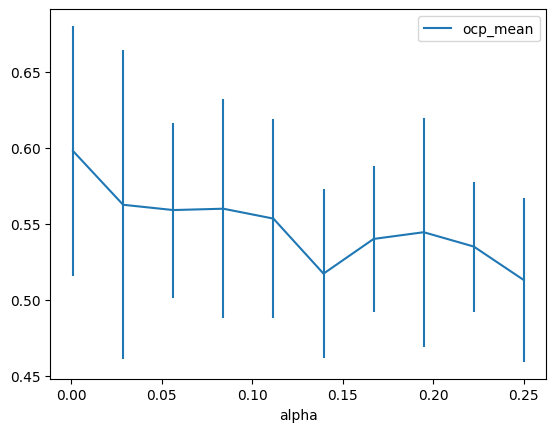

In [20]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

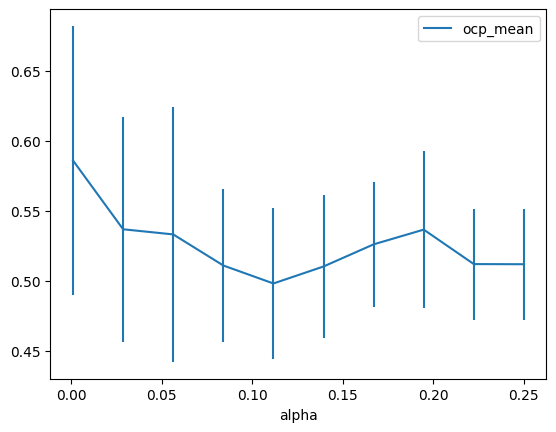

In [21]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

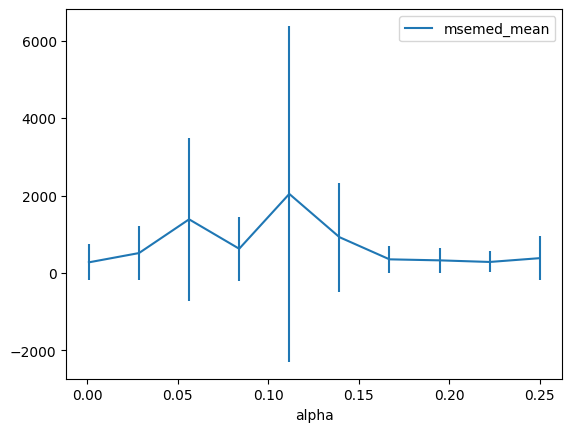

In [22]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

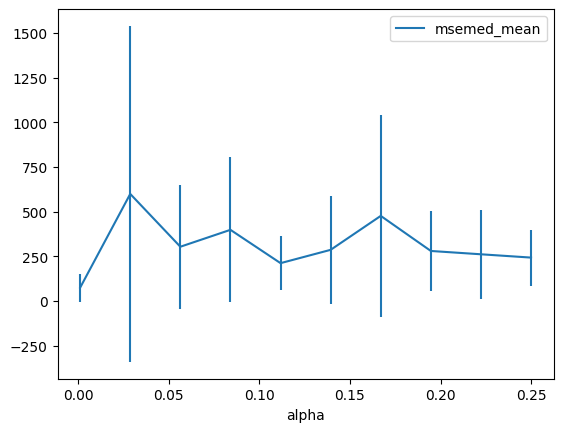

In [23]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha, though again there is a large error bar. We explore the low range of alpha in more detail, both with and without averaging. 

In [24]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.15, num=10)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r) 

0.001 True 0.6061059742988517 21.0274260242204
0.017555555555555557 True 0.603482972731481 119.06622282534917
0.03411111111111111 True 0.5826766949734437 155.22386444500535
0.050666666666666665 True 0.5547979831091828 123.3098844260104
0.06722222222222222 True 0.5517774201233031 189.200689804356
0.08377777777777778 True 0.5588618749814614 218.8054360863221
0.10033333333333333 True 0.5442158790867895 188.4424849499424
0.11688888888888889 True 0.583342351612678 260.10004359466876
0.13344444444444445 True 0.5319741079431237 251.9716684860744
0.15 True 0.5346244731242399 202.84392606102915
0.001 False 0.6105703939883756 48.148095071796604
0.017555555555555557 False 0.582568554018323 121.09774683215774
0.03411111111111111 False 0.5694762390183596 161.73292110209306
0.050666666666666665 False 0.5539962762630303 220.5335170836048
0.06722222222222222 False 0.546210563808377 227.41334483847936
0.08377777777777778 False 0.5427076930452868 168.05635322502235
0.10033333333333333 False 0.5418655022

In [25]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.598327,0.101552,91.723966,121.674002
1,0.017556,True,0.588453,0.064183,238.076891,224.754615
2,0.034111,True,0.573841,0.066443,476.197925,583.975612
3,0.050667,True,0.549711,0.075664,524.539363,840.362310
4,0.067222,True,0.564345,0.076978,488.661462,463.025208


We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

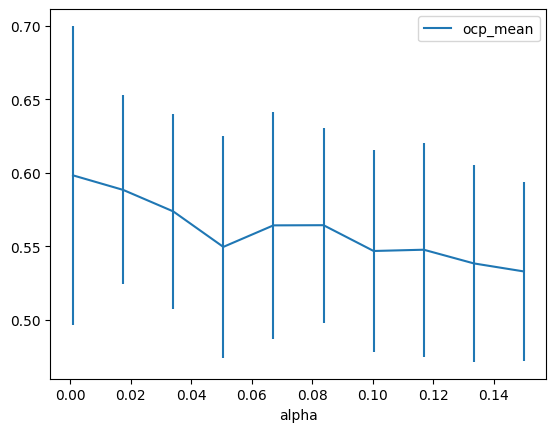

In [26]:
%matplotlib inline

df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

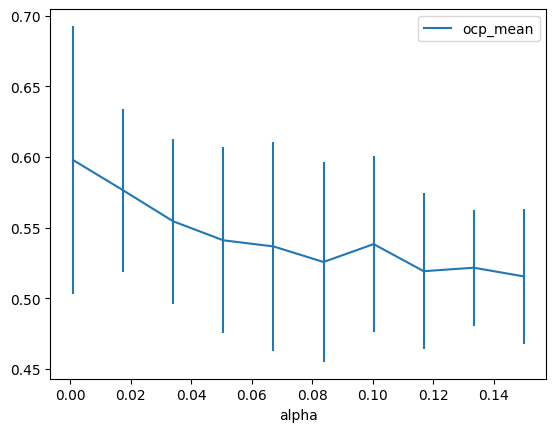

In [27]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

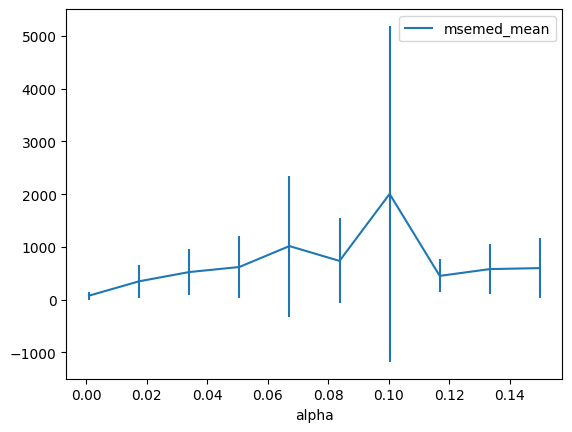

In [28]:
df[df.avg == False].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

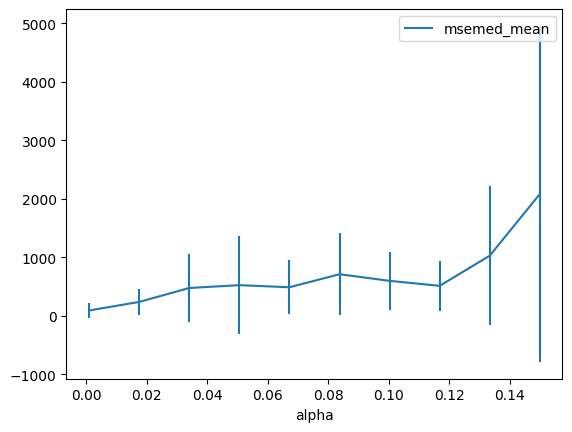

In [29]:
df[df.avg == True].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

We again look at the numbers.

In [30]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.598327,0.101552,91.723966,121.674002
1,0.017556,True,0.588453,0.064183,238.076891,224.754615
2,0.034111,True,0.573841,0.066443,476.197925,583.975612


In [31]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.597836,0.094804,75.157494,73.341848
11,0.017556,False,0.576399,0.057522,347.401115,317.479899
12,0.034111,False,0.554446,0.058521,522.833186,434.469643


In [32]:
df[df.avg == False].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.597836,0.094804,75.157494,73.341848
11,0.017556,False,0.576399,0.057522,347.401115,317.479899
17,0.116889,False,0.519182,0.055001,450.200295,312.428586


In [33]:
df[df.avg == True].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.598327,0.101552,91.723966,121.674002
1,0.017556,True,0.588453,0.064183,238.076891,224.754615
2,0.034111,True,0.573841,0.066443,476.197925,583.975612


### Parameters for the fitted model with seed dimensions



**BERT last 4 layers**

Best performance is for lowest values of alpha. In terms of OC_P, it does not matter whether we average or not, but MSE values are lower with averaging, so we choose **alpha = 0.001, with averaging**

**RoBERTA last 4 layers**

Best performance is again for lowest values of alpha, and performance is slightly better with averaging so we again use **alpha = 0.001, with averaging**

In [34]:
raise Exception("stop")

Exception: stop

# Combined model: seeds as words and dimensions

We fix jitter, offset, and averaging to the best values determined above as they don't seem to have made much of a difference.


In [35]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.15, num=10)
jitter_vals = [False]
offset_vals= [ 1.0]


results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    
                    ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
                    _, mse_med, _ = eval_summary_by(theseresults, "mse")
                    print(alphaval, avgval, oval, jval, ocp_mean, mse_med)
            
            
                    for r in theseresults:
                        r.update({"alpha":alphaval, "avg": avgval, "offset": oval, "j": jval})
                        results[ (str(alphaval), str(avgval))].append(r) 




0.001 True 1.0 False 0.6043289603173724 2.6217081484218534
0.017555555555555557 True 1.0 False 0.705074090118007 1.93642050720864
0.03411111111111111 True 1.0 False 0.6821348947859583 2.282774456102352
0.050666666666666665 True 1.0 False 0.6657363422580193 2.9558721287654546
0.06722222222222222 True 1.0 False 0.6548817643363593 3.0223295873301
0.08377777777777778 True 1.0 False 0.633769951103105 3.2539449634895976
0.10033333333333333 True 1.0 False 0.6179031664731698 4.699358101297003
0.11688888888888889 True 1.0 False 0.6115489750267494 5.882717108206861
0.13344444444444445 True 1.0 False 0.6114124651274899 5.940899106391399
0.15 True 1.0 False 0.6190128996924624 5.40006178862545
0.001 True 1.0 False 0.616195490334783 5.998420612500406
0.017555555555555557 True 1.0 False 0.6930569365724712 2.268637112607673
0.03411111111111111 True 1.0 False 0.6747274216883933 2.970631062516464
0.050666666666666665 True 1.0 False 0.6611341317452063 2.643670626077643
0.06722222222222222 True 1.0 False 

In [36]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg", "offset", "j"]))
df.head()


,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,1.0,False,0.607946,0.099839,4.023332,1.301894
1,0.017556,True,1.0,False,0.698994,0.036740,1.958062,0.569922
2,0.034111,True,1.0,False,0.679745,0.045192,2.460285,0.886735
3,0.050667,True,1.0,False,0.670733,0.037186,2.393701,0.779273
4,0.067222,True,1.0,False,0.653847,0.041345,3.331200,0.971976


## Plotting the results



<AxesSubplot: xlabel='alpha'>

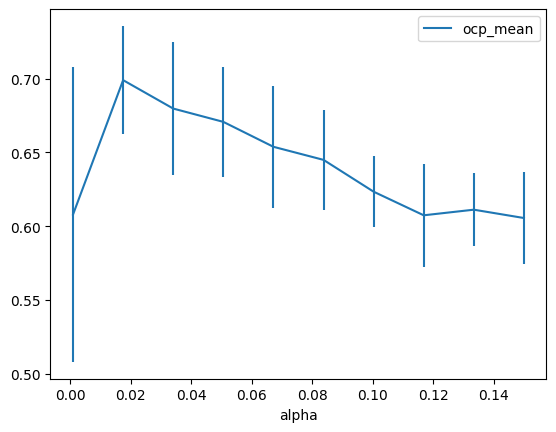

In [37]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

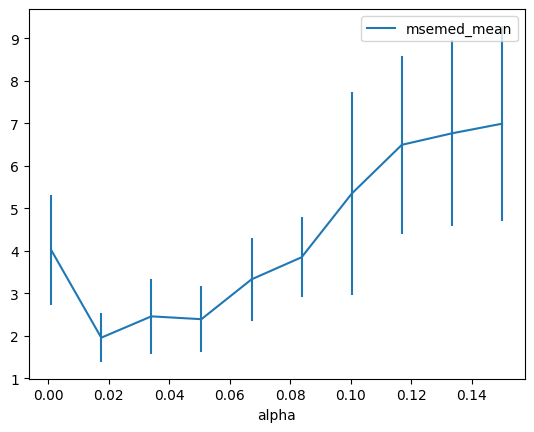

In [38]:
df.plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [39]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
1,0.017556,True,1.0,False,0.698994,0.036740,1.958062,0.569922
2,0.034111,True,1.0,False,0.679745,0.045192,2.460285,0.886735
3,0.050667,True,1.0,False,0.670733,0.037186,2.393701,0.779273
4,0.067222,True,1.0,False,0.653847,0.041345,3.331200,0.971976
5,0.083778,True,1.0,False,0.644986,0.033746,3.850996,0.945957


In [40]:
df.sort_values(by = "msemed_mean", ascending = True).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
1,0.017556,True,1.0,False,0.698994,0.036740,1.958062,0.569922
3,0.050667,True,1.0,False,0.670733,0.037186,2.393701,0.779273
2,0.034111,True,1.0,False,0.679745,0.045192,2.460285,0.886735
4,0.067222,True,1.0,False,0.653847,0.041345,3.331200,0.971976
5,0.083778,True,1.0,False,0.644986,0.033746,3.850996,0.945957


### Parameters for the fitted model with seed words and seed dimensions


**BERT last 4 layers**

Both OC_P and MSE have a clear best value at **alpha = 0.02**. We use **averaging, no jitter, and an offset of 1.0**,

**RoBERTA last 4 layers**

Again, clear best value is **alpha = 0.02**. We use **averaging, no jitter, and an offset of 1.0**,

